Данные содержат тренировочную (ranking_train.jsonl) и тестовую (ranking_test.jsonl) выборки.

В каждом файле почти одинаковый формат:
- Отдельная строчка в файле — валидный JSON с семплом
- Каждый JSON имеет поле text с текстом поста и массив сomments из 5 элементов
- Каждый элемент массива это словарь с ключами text с текстом комментария и score с позицией ранжирования (0 cоответствует самому популярному комментарию, 4 самому непопулярному)
- В тестовом файле в поле score стоит null

Заполните тестовую выборку, т.е. расставьте в файле ranking_test.jsonl вместо null значения score. В рамках одного семпла они должны быть от 0 до 4 и не должны повторяться.
Пришлите файл с результатами вместе с кодом и презентацией.

По валидации - будем смотреть на NDCG метрику (hint: она уже есть в библиотеке sklearn). 
В целом, хочется видеть рассуждения, поэтому можно предлагать и другие способы оценки.

# Подключение библиотек

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import pandas as pd
import json
!pip install "sagemaker>=2.48.0"  --upgrade
import sagemaker.huggingface

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.5/684.5 KB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.1/135.1 KB 751.6 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 KB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 48.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 KB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 10.2 MB/s eta 0:00:00
  Created wheel for sagemaker: filename=sagemaker-2.140.0-py2.py3-none-any.whl size=925364 sha256=68cbc5a40237a6263540785a9e5205acd331d18278c4ab8017abf05ef7ba1bba
  Stored in

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
!pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import sklearn as sk

In [5]:
!pip install split-folders 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import splitfolders

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
import numpy as np

In [8]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
from sklearn import metrics

# Подключение к google disk

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ranking_test = pd.read_json('/content/drive/MyDrive/Hack_DS/ranking_test.jsonl', lines=True, convert_dates=False, orient='columns') #вау считали джсон
ranking_test.head()

,text,comments
0,"iOS 8.0.1 released, broken on iPhone 6 models,...",[{'text': 'I&#x27;m still waiting for them to ...
1,Ask HN: How do US HNers get their health insur...,[{'text': 'Get it from your employer. It&#x27;...
2,San Diego Researcher Crowdfunding Patent-Free ...,[{'text': 'What I don&#x27;t understand is why...
3,Rethinking the origins of the universe,[{'text': 'I&#x27;m not a physicist. I imagin...
4,SlackTextViewController: A new growing text in...,[{'text': 'As someone that doesn&#x27;t do iOS...


In [ ]:
ranking_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14004 entries, 0 to 14003
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      14004 non-null  object
 1   comments  14004 non-null  object
dtypes: object(2)
memory usage: 218.9+ KB


In [ ]:
ranking_test['comments']

0        [{'text': 'I&#x27;m still waiting for them to ...
1        [{'text': 'Get it from your employer. It&#x27;...
2        [{'text': 'What I don&#x27;t understand is why...
3        [{'text': 'I&#x27;m not a physicist.  I imagin...
4        [{'text': 'As someone that doesn&#x27;t do iOS...
                               ...                        
13999    [{'text': 'Meanwhile in the US, Stubbs has bee...
14000    [{'text': 'A radical idea: Maybe our model of ...
14001    [{'text': 'Was the presentation more in-depth ...
14002    [{'text': 'Ok now I want to &quot;hear&quot; o...
14003    [{'text': 'I send a LOT of emails each month (...
Name: comments, Length: 14004, dtype: object

# Работа с ranking_train

In [10]:
ranking_train = pd.read_json('/content/drive/MyDrive/Hack_DS/ranking_train.jsonl', lines=True, convert_dates=False) #вау считали уже другой джсон
ranking_train.head()

,text,comments
0,How many summer Y Combinator fundees decided n...,[{'text': 'Going back to school is not identic...
1,CBS acquires last.fm for $280m,[{'text': 'It will be curious to see where thi...
2,How Costco Became the Anti-Wal-Mart,[{'text': 'I really hate it when people falsel...
3,"Fortune Favors Big Turds | Screw The Money, Th...",[{'text': 'His real point is that something ca...
4,StartupWeekend: 70 Founders Create One Company...,[{'text': 'Looks like someone hasn't read The ...


удаляем стоп-слова

In [11]:
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
stop_words = stopwords.words('english')
print(stop_words) #вывели стоп-слова

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [12]:
nltk.download('punkt')
nltk.download('wordnet') # проводит лемматизацию
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


# Жесткий кодинг

Функция разделения текста на ключевые слова:

In [ ]:
from pandas.core.frame import rewrite_axis_style_signature
def only_words(index: int, key: str, comment_index = 0 ):
  import re
  global ranking_train
  line = ranking_train.iloc[index]
  if(key == 'text'):
    text = line['text']

  elif(key == 'comments'):
   # print(line)
    text = line['comments'][comment_index]['text']
  elif(key == 'score'):
    return line['comments'][comment_index]['score']
  #print(text)
  rew = re.sub(re.compile('[^A-Za-z]+'), ' ', text) #оставляем только слова в посте
  #print(rew)
  rew = rew.lower() #все делаем нижнего регистра
  #print(rew)
  rew = nltk.word_tokenize(rew) #разбили предложения на токены
  #print(rew)
  lemmatize = nltk.WordNetLemmatizer()
  rew = [lemmatize.lemmatize(word) for word in rew]
  rew = [word for word in rew if( word not in stop_words and len(word)>=3)] #удалили стоп-слова
  
  return rew
# only_words(5, 'comments', 1)

In [ ]:
changed_rt = pd.DataFrame({"text":[],"comments":[]})
for i in range(len(ranking_train)):
  
  #new_df = pd.DataFrame({"index":[i],"text":[only_words(i,'text')],"comments":[{'text':only_words(i,'comments', j),'score': -1} for j in range(len(ranking_train.iloc[i]['comments']))]})
  changed_rt.loc[len(changed_rt.index)] = [only_words(i,'text'),
                                           [{'text':only_words(i,'comments', j),
                                             'score': only_words(i,'score', j)} for j in range(len(ranking_train.iloc[i]['comments']))]]
changed_rt

/usr/local/lib/python3.9/dist-packages/pandas/core/dtypes/cast.py:883: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)


,text,comments
0,"[many, summer, combinator, fundees, decided, c...","[{'text': ['going', 'back', 'school', 'identic..."
1,"[cbs, acquires, last]","[{'text': ['curious', 'see', 'head', 'long', '..."
2,"[costco, became, anti, wal, mart]","[{'text': ['really', 'hate', 'people', 'falsel..."
3,"[fortune, favor, big, turd, screw, money, art]","[{'text': ['real', 'point', 'something', 'simp..."
4,"[startupweekend, founder, create, one, company...","[{'text': ['look', 'like', 'someone', 'read', ..."
...,...,...
88102,"[upgrade, may, experience, service]","[{'text': ['issue', 'able', 'fix', 'ota', 'upd..."
88103,"[ask, hners, get, health, insurance]","[{'text': ['use', 'hsa', 'qualified', 'high', ..."
88104,"[justin, gordon, using, react, rail]","[{'text': ['neat', 'insight', 'friend', 'mine'..."
88105,"[released, broken, iphone, model, withdrawn]","[{'text': ['ouch', 'feel', 'whoever', 'let', '..."


Сохраняем полученные данные в json файл

In [ ]:
json_train = changed_rt.to_json(orient='split')
with open('/content/drive/MyDrive/Hack_DS/my_data.json', 'w') as f:
 f.write(json_train)

# Анализ по количеству повторений

Анализ количества повторения слов

In [13]:
changed_rt = pd.read_json('/content/drive/MyDrive/Hack_DS/my_data.json', convert_dates=False, orient='split' )

In [ ]:
words_dict = {}
flag = 0
for i in range(len(changed_rt)):
  flag += 1
  line = changed_rt.iloc[i]['comments']
  if(flag == 1000):
    pass
    #break
  for l in range(len(line)):
    
    comm_text = changed_rt.iloc[i]['comments'][l]['text']
    comm_score = changed_rt.iloc[i]['comments'][l]['score']
    for word in comm_text:
      
      if(word not in words_dict):
        words_dict[word] = np.array([1,comm_score])
      else:
        words_dict[word] += np.array([1,comm_score])
new_df = pd.DataFrame(words_dict)
new_df


,going,back,school,identical,giving,founder,keep,working,startup,however,...,jsnell,humana,mdvip,goodrx,dopeness,amato,onlinebanking,yapstone,rentpayment,radpad
0,44191,32538,15316,926,5637,9271,20596,25619,26072,15594,...,1,2,2,3,1,1,1,1,1,1
1,68868,50869,23694,1319,9060,14047,32657,40441,41759,23974,...,1,0,0,4,4,0,0,3,3,3


In [ ]:
json_train = new_df.to_json(orient='split')
with open('/content/drive/MyDrive/Hack_DS/word_count.json', 'w') as f:
 f.write(json_train)

In [ ]:
json_train = words_count_df.to_json(orient='split')
with open('/content/drive/MyDrive/Hack_DS/words_count_df.json', 'w') as f:
 f.write(json_train)

# TF IDF

In [ ]:
word_count = pd.read_json('/content/drive/MyDrive/Hack_DS/word_count.json', convert_dates=False, orient='split' )

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

In [16]:
def tf_idf_avg_diff(changed_rt): 
  tfIdfVectorizer=TfidfVectorizer(use_idf=True) 
  res = [] 
  everage = [] 
  slova_tfidf = dict() 
  for i in range(len(changed_rt)): 
 
    comm_text = [] 
    for j in range(len(changed_rt.iloc[i]["comments"])): 
      comm_text.append(' '.join(changed_rt.iloc[i]["comments"][j]["text"])) 
    comm_text.append(' '.join(changed_rt.iloc[i]["text"])) 
    tfIdf = tfIdfVectorizer.fit_transform(comm_text) 
 
    feature_names = tfIdfVectorizer.get_feature_names_out() # приведение дата фрейма к красивому рабочему виду 
    dense = tfIdf.todense() 
    denselist = dense.tolist()    
 
     
    sum = 0 
    for j in range(len(denselist) - 1): 
      for x, y in zip(denselist[j], denselist[-1]): 
        sum += abs(x - y) 
      if len(denselist[j]) != 0: 
        everage.append(sum / len(denselist[j])) 
      else: 
        everage.append(0.0) 
 
  return everage

In [17]:
tfIdf_diff = tf_idf_avg_diff(changed_rt)

# Коэф Жаккара

In [ ]:
def jaccard_set(list1, list2): # находит коэффициент для 2х списков слов
  intersection = len(list(set(list1).intersection(list2)))
  union = (len(list1) + len(list2)) - intersection
  if union == 0:
    return 1
  return float(intersection) / union 

In [ ]:
jac = []
k = -1
for i in range(len(changed_rt)):
  for j in range(len(changed_rt.iloc[i]['comments'])):
    jac.append([])
    k+=1
    jac[k].append(jaccard_set(changed_rt.iloc[i]['text'], changed_rt.iloc[i]['comments'][j]['text']))

In [ ]:
jac

# Графички

In [40]:
import matplotlib.pyplot as plt
import numpy as np


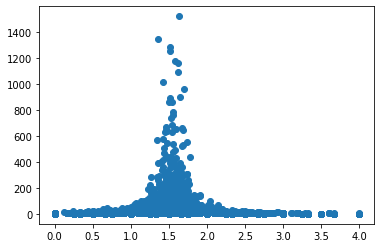

In [ ]:
words_count_df = pd.read_json('/content/drive/MyDrive/Hack_DS/words_count_df.json', convert_dates=False, orient='split' )
plt.scatter(np.array(words_count_df.iloc[1])/np.array(words_count_df.iloc[0]), np.array(words_count_df.iloc[0]))
plt.show()

По графикe можно сделать вывод, что частота повторения слова не оказывает большого влияния на score комментария.

<AxesSubplot:xlabel='word', ylabel='count'>

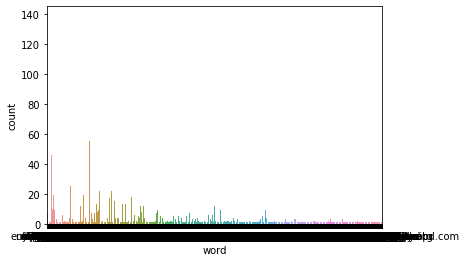

In [ ]:
sns.barplot(data=words_count_df, x=words_count_df['word'], y=words_count_df['count'])

# Анализ по настроению (не работает)

Анализ комментариев по настроению:

In [ ]:
!pip install transformers
from transformers import pipeline
classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", tokenizer ="j-hartmann/emotion-english-distilroberta-base" ,return_all_scores=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 99.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 109.4 MB/s eta 0:00:00


/usr/local/lib/python3.9/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
from nltk.tokenize import sent_tokenize
def text_to_statements(text):
  return sent_tokenize(text)


In [ ]:
def classifier_to_list(vect):
  res = []
  for i in range(len(vect[0])):
    res.append(vect[0][i]['score'])
  return res

In [ ]:
import re
data_mood = []
flag = 0
for i in range(len(ranking_train), ):
  flag += 1
  if(flag == 100):
    break
  text = re.sub(re.compile('[^A-Za-z0-9!?.]+'), ' ', ranking_train.iloc[i]["text"])
  # text = ranking_train.iloc[i]["text"]
  tokenize_text = sent_tokenize(text)
  vector_text = np.array([0. for i in range(7)])
  for token in tokenize_text:
    #print(np.array(classifier_to_list(classifier(text))))
    vector_text += np.array(classifier_to_list(classifier(token)))
  vector_text = vector_text/len(tokenize_text)
  for j in range(len(ranking_train.iloc[i]["comments"])):
    #flag += 1
    # if flag % 500 == 0:

    comm_text = re.sub(re.compile('[^A-Za-z!?.]+'), ' ', ranking_train.iloc[i]["comments"][j]["text"])
    # print(i, j)
    tokenize_comm = text_to_statements(comm_text)
    vector_comm = np.array([0. for i in range(7)])
    for token in tokenize_comm:
      vector_comm = np.array(classifier_to_list(classifier(token)))
    vector_comm = vector_comm/len(tokenize_comm)
    data_mood.append([i, j, vector_text, vector_comm])
data_mood

KeyboardInterrupt: ignored

In [ ]:
import re
data_mood = pd.DataFrame({"index_post" : [], "index_comm" : [], "vector_text" : [], "vector_comm" : []})
flag = 0
for i in range(len(ranking_train)):
  flag += 1
  if(flag == 100):
    break
  text = re.sub(re.compile('[^A-Za-z0-9!?.]+'), ' ', ranking_train.iloc[i]["text"])
  # text = ranking_train.iloc[i]["text"]
  tokenize_text = sent_tokenize(text)
  vector_text = np.array([0. for i in range(7)])
  for token in tokenize_text:
    #print(np.array(classifier_to_list(classifier(text))))
    vector_text += np.array(classifier_to_list(classifier(token)))
  vector_text = vector_text/len(tokenize_text)
  for j in range(len(ranking_train.iloc[i]["comments"])):
    flag += 1
    # if flag % 500 == 0:

    comm_text = re.sub(re.compile('[^A-Za-z!?.]+'), ' ', ranking_train.iloc[i]["comments"][j]["text"])
    # print(i, j)
    tokenize_comm = text_to_statements(comm_text)
    vector_comm = np.array([0. for i in range(7)])
    for token in tokenize_comm:
      vector_comm = np.array(classifier_to_list(classifier(token)))
    vector_comm = vector_comm/len(tokenize_comm)
    data_mood.loc[len(data_mood.index)] = [i, j, vector_text, vector_comm]
data_mood


/usr/local/lib/python3.9/dist-packages/pandas/core/dtypes/cast.py:883: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)
<ipython-input-24-f2822ebda801>:23: RuntimeWarning: invalid value encountered in true_divide
  vector_comm = vector_comm/len(tokenize_comm)
<ipython-input-24-f2822ebda801>:23: RuntimeWarning: invalid value encountered in true_divide
  vector_comm = vector_comm/len(tokenize_comm)


KeyboardInterrupt: ignored

In [ ]:
text_to_statements(ranking_train.iloc[21]['comments'][0]['text'])


['Sounds like you have a fun opportunity lined up.',
 'I would personally try to broaden your message some.',
 'Kids get told what they should do all the time.',
 "I would tell them that one of life's true joys is to find something you love and to spend your life working on it.",
 'Then you could segue into a discussion of how hacking has been a personal source of meaning for you.',
 "Talk about the points you mention above, and then bring it full circle by telling them that any road they walk down can be equally fulfilling if they find something they truly care for: life's value derives from what we do, not what we have.",
 'Hope your talk goes well, and keep in mind there is probably a reason you are being asked to give a talk and not me.',
 ';)']

In [ ]:
[classifier_to_list(classifier(comm_text)) for comm_text in text_to_statements(ranking_train.iloc[21]['comments'][0]['text'])]

[[0.006236780900508165,
  0.01329336129128933,
  0.007864715531468391,
  0.0019117436604574323,
  0.9428667426109314,
  0.013555590063333511,
  0.014271117746829987],
 [0.022896911948919296,
  0.0061022150330245495,
  0.03220071643590927,
  0.04045698419213295,
  0.608411431312561,
  0.010608170181512833,
  0.279323548078537],
 [0.010876964777708054,
  0.02178540639579296,
  0.0009544277563691139,
  0.8662817478179932,
  0.08173715323209763,
  0.01258272398263216,
  0.005781605839729309],
 [0.022470517084002495,
  0.04291210323572159,
  0.001853829133324325,
  0.6647719740867615,
  0.25469306111335754,
  0.0073922174051404,
  0.005906269419938326],
 [0.020945489406585693,
  0.08558546751737595,
  0.018997149541974068,
  0.0033087253104895353,
  0.8225994110107422,
  0.008769155479967594,
  0.03979460522532463],
 [0.818047285079956,
  0.1329910159111023,
  0.0062552690505981445,
  0.0012465327745303512,
  0.022665726020932198,
  0.01721576787531376,
  0.0015784032875671983],
 [0.5253862

In [ ]:
classifier('I love you') #это мы просто пример смотрели

[[{'label': 'anger', 'score': 0.00220660911872983},
  {'label': 'disgust', 'score': 0.0011457924265414476},
  {'label': 'fear', 'score': 0.0005955399246886373},
  {'label': 'joy', 'score': 0.9687249660491943},
  {'label': 'neutral', 'score': 0.0055024814791977406},
  {'label': 'sadness', 'score': 0.01692713424563408},
  {'label': 'surprise', 'score': 0.004897605162113905}]]

Расчет вектора поста по индексу:

In [ ]:
#from pandas.core.indexers.utils import DataFrame
def vec_by_index(index: int, df):
  line = df.iloc[index]
  text = line["text"]
  text = text.translate({ord(i): None for i in '()/$%#@!$%&\\'}).lower()
  text_list = text.split(' ')
  print(text)
  
vec_by_index(5, ranking_train)

younger job seekers hold the advantage because they can do startups instead


In [ ]:
[s.translate({ord(i): None for i in '()/$%#@$%&\\~'}).lower().split(' ') for s in ranking_train['text'].unique()] #уникальные слова для каждого коммента


[['how',
  'many',
  'summer',
  'y',
  'combinator',
  'fundees',
  'decided',
  'not',
  'to',
  'continue',
  'with',
  'their',
  'startup',
  'and',
  'go',
  'back',
  'to',
  'school?',
  'and',
  'what',
  'were',
  'the',
  'reasons?'],
 ['cbs', 'acquires', 'last.fm', 'for', '280m'],
 ['how', 'costco', 'became', 'the', 'anti-wal-mart'],
 ['fortune',
  'favors',
  'big',
  'turds',
  '|',
  'screw',
  'the',
  'money,',
  'this',
  'is',
  'my',
  'art'],
 ['startupweekend:',
  '70',
  'founders',
  'create',
  'one',
  'company',
  'in',
  'a',
  'weekend'],
 ['younger',
  'job',
  'seekers',
  'hold',
  'the',
  'advantage',
  'because',
  'they',
  'can',
  'do',
  'startups',
  'instead'],
 ['four', 'pownce', 'invites'],
 ['lfms', 'and', 'lfsps', 'michael', 'vanier', 'via', 'pg'],
 ['the', 'virtues', 'of', 'a', 'second', 'screen'],
 ['startup', 'weekend', 'failed,', 'but', 'lessons', 'learned'],
 ['matt',
  'maroon:',
  'advice',
  'for',
  'would-be',
  'y',
  'combinator'

In [ ]:
ranking_train['comments']

0        [{'text': 'Going back to school is not identic...
1        [{'text': 'It will be curious to see where thi...
2        [{'text': 'I really hate it when people falsel...
3        [{'text': 'His real point is that something ca...
4        [{'text': 'Looks like someone hasn't read The ...
                               ...                        
88102    [{'text': 'I had this issue and was able to fi...
88103    [{'text': 'We use a HSA-qualified high-deducti...
88104    [{'text': 'neat insight! A friend of mine conv...
88105    [{'text': 'Ouch, I feel for whoever let this s...
88106    [{'text': 'Most major banks offer a service ca...
Name: comments, Length: 88107, dtype: object

теперь хотя бы понятна структура данных

In [ ]:
ranking_train.isnull().sum()

https://huggingface.co/models



https://habr.com/ru/post/264339/

надо провести проверку и разведочный анализ данных 

https://habr.com/ru/company/wunderfund/blog/662547/

ранжирование:
1. разбиваем пост на слова, слова превращаем в вектор
2. ищем сумму векторов
3. для каждого коммента делаем то же самое
4. сравниваем вектора коммента и поста


In [ ]:
from sklearn.datasets import fetch_20newsgroups

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
count_vect = CountVectorizer()

In [ ]:
classifier('I hate you')

# Записываем скоры

In [ ]:
def scores():
  df_scores = []
  for i in range(len(ranking_train)):
    df_scores.append([])
    for j in range(len(ranking_train.iloc[i]['comments'])):
      df_scores[i].append([])
      df_scores[i][j].append(ranking_train.iloc[i]["comments"][j]["score"])

  return df_scores

In [ ]:
def scores_jac():
  df_scores = []
  for i in range(len(changed_rt)):
    for j in range(len(changed_rt.iloc[i]['comments'])):
      df_scores.append(changed_rt.iloc[i]["comments"][j]["score"])

  return df_scores

In [ ]:
y = scores()

KeyboardInterrupt: ignored

In [ ]:
y_jac = scores_jac()

In [ ]:
x = tf_idf()

In [ ]:
x_jac = jac

In [ ]:
x_jac_slice = x_jac[:len(x_jac)//10]
y_jac_slice = y_jac[:len(y_jac)//10]

In [ ]:
y_slice = y[:len(y)//10]
x_slice = x[:len(x)//10]


In [ ]:
from sklearn.model_selection import train_test_split

# Работаем с моделями

# Адаптивный бустинг

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

In [19]:
x = [[tf] for tf in tfIdf_diff]

In [20]:
y = [] 
for i in range(len(changed_rt)): 
  for j in range(len(changed_rt.iloc[i]["comments"])): 
    y.append([changed_rt.iloc[i]["comments"][j]["score"]])

In [ ]:
Y = [] 
for j in range(5): 
  Y.append([]) 
  for i in range(len(y)): 
    Y[j].append([y[i][0] == j])

In [ ]:
modelClf = [] 
modelclf_fit = [] 
for i in range(5): 
  modelClf.append(AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), n_estimators=100, random_state=42)) 
  X_train, X_valid, y_train, y_valid = train_test_split(x, Y[i], test_size = 0.3, random_state = 42) 
  modelclf_fit.append(modelClf[i].fit(X_train, y_train)) 
  print(modelClf[i].score(X_valid, y_valid))

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.9116153782129373


/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.813757462488934


/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.7991767616770454


/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.7979131513835398


/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.8369791390803641


In [ ]:
y_pred = [] 
ochered = [0, 4, 2, 1, 3]
for i in range(1, len(x) // 5 + 1):
  if i == 2:
    break
  x_post = x[(i - 1) * 5 : i * 5] 
  y_post = [-1, -1, -1, -1, -1] 
  for j in range(5): 
    if j == 2: 
      continue 
    y_pred_post = modelclf_fit[ochered[j]].predict(x_post)
    print(y_pred_post)
    for k in range(len(y_pred_post)):
      if y_pred_post[k] == 1:
        print(k) 
        kk = 0
        jj = 0
        for jj in range(5):

          if kk == k and y_post[jj] == -1:
            print('!!!!!!')
            y_post[jj] = ochered[j]
            print('!!', y_post[jj])
            x_post.pop(k) 
            break
          if y_post[jj] == -1:
            kk += 1
        break 
   
  for j in range(5): 
    if y_post[j] == -1: 
      y_pred.append(2) 
    else: 
      y_pred.append(y_post[j])
print(y_pred)
 
metrics.accuracy_score(Y[0][:5], y_pred)

In [ ]:
y_pred = [] 
ochered = [0, 4, 1, 3, 2] 
for i in range(1, 2 + 1): 
  x_post = x[(i - 1) * 5 : i * 5] 
  y_post = [-1, -1, -1, -1, -1] 
  used = ochered.copy() 
  j = 0 
  step_count = 0 
  max_step = 11
  while len(used) >= 1 and step_count < max_step:
    j += 1 
    if j >= 5: 
      j = 0 
    y_pred_post = modelclf_fit[used[j % len(used)]].predict(x_post) 
    for k in range(len(y_pred_post)): 
      if y_pred_post[k] == 1: 
        kk = 0 
        jj = 0 
        while kk != k or y_post[jj] != -1: 
          kk += (y_post[jj] == -1) 
          jj += 1 
        y_post[jj] = used[j % len(used)] 
        x_post.pop(k) 
        used.pop(j % len(used)) 
        j -= 1 
        max_step -= 1 
        break 
    step_count += 1 
   
  for j in range(5): 
    if y_post[j] == -1: 
      y_pred.append(used[0]) 
      used.pop(0) 
    else: 
      y_pred.append(y_post[j])

In [21]:
X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.3, random_state = 42) 

In [22]:
accuracy = {}

In [23]:
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

clf = SGDClassifier(max_iter=10000, tol=1e-8)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_valid)
accuracy['SGDClassifier'] = metrics.accuracy_score(y_valid, y_pred)
print(accuracy['SGDClassifier'])


/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.45067001611670615


In [24]:
abc = AdaBoostClassifier(n_estimators=60,learning_rate=1)
model = abc.fit(X_train, y_train)
y_pred_ada = model.predict(X_valid)
accuracy['AdaBoostClassifier'] = metrics.accuracy_score(y_valid, y_pred_ada)
print(accuracy['AdaBoostClassifier'])
# print("Accuracy:",metrics.accuracy_score(y_valid, y_pred_ada))

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5022056431171071


In [ ]:
abc_2 = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2), n_estimators=60, random_state=42)
model = abc_2.fit(X_train, y_train)
y_pred_ada_2 = model.predict(X_valid)
accuracy['AdaBoostClassifier'] = metrics.accuracy_score(y_valid, y_pred_ada_2)
print("Accuracy:",metrics.accuracy_score(y_valid, y_pred_ada_2))

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.5297629406557154


# Градиентный бустинг

In [25]:
grad = GradientBoostingClassifier(max_depth=2, n_estimators=150,random_state=12, learning_rate=2)
grad.fit(X_train, y_train)
grad.score(X_valid, y_valid)
y_pred_grad = grad.predict(X_valid)
# metrics.accuracy_score(y_valid, y_pred_grad)
accuracy['GradientBoostingClassifier'] = metrics.accuracy_score(y_valid, y_pred_grad)
print(accuracy['GradientBoostingClassifier'])

/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.17005773261400867


# Метод опорных векторов

График сравнения точности всех рассмотренных моделей

In [ ]:
from sklearn import svm
metodsvm = svm.SVC()
metodsvm.fit(X_train, y_train)
metodsvm.score(X_valid, y_valid)
y_pred_svm = metodsvm.predict(X_valid)
accuracy['SVM'] = metrics.accuracy_score(y_valid, y_pred_grad)
print(accuracy['SVM'])

In [31]:
accuracy.keys()

TypeError: ignored

In [38]:
x_keys = [i for i in accuracy.keys()]
y_vals = [i for i in accuracy.values()]
accuracy.values()

dict_values([0.45067001611670615, 0.5022056431171071, 0.17005773261400867])

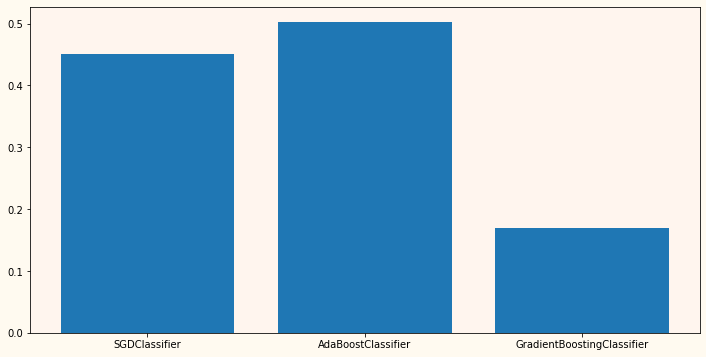

In [48]:
# hist,bins=np.histogram(img)
fig, ax = plt.subplots()
ax.bar(x_keys, y_vals)
ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(12)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure
plt.show()


# Последовательно раставляем скоры

In [ ]:
for i in range(len(x) / 5):
  x_post = x[i * 5 : (i - 1) * 5 - 1]
  y_post = [-1, -1, -1, -1, -1]
  for j in range(5): 
    y_pred = modelclf_fit[j].predict(x_post)
    for k in range(len(y_pred)): 
      if y_pred[k] == 1:
        y_post[k] = j
        x.pop()
        break
  metrics.accuracy_score(Y[0], y_pred)